# specx_specxy_anal

This example demonstrates how to perform 1 and 2-dimensional analysis using the `scipy.signal` module. To learn more about the functions and keyword arguments available in this package, read Scipy's [Signal Processing documentation](https://docs.scipy.org/doc/scipy/reference/signal.html).

The motivation for this example is to demonstrate how to perform the spectral analysis suite of NCl functions: [`specx_anal()`](https://www.ncl.ucar.edu/Document/Functions/Built-in/specx_anal.shtml) and [`specxy_anal()`](https://www.ncl.ucar.edu/Document/Functions/Built-in/specxy_anal.shtml), which calculate the spectra of a series, in Python.

This notebook will cover:

1. Periodograms
1. Smoothing
1. Cross Spectral Analysis (cospectrum, quadtrature, phase, coherence squared)
1. Coherence

For more examples of use, look at [NCL spectral analysis applications](https://www.ncl.ucar.edu/Applications/spec.shtml).

To see a concise example using Python, visit the [spectral_analysis](`../../applications/data_analysis/spectral_analysis.ipynb`) notebook.

## 1-D Spectral Analysis (Periodograms)

According to the [NCL `specx_anal()` documentation](https://www.ncl.ucar.edu/Document/Functions/Built-in/specx_anal.shtml), the function:

1. Optionally detrends the series
2. Optionally tapers the series
3. Calculates the variance of the detrended/tapered series
4. Finds the Fast Fourier Transform of the series
5. Squares the Fourier coefficients (i.e. the periodogram)
6. Smooths the periodogram estimates 
7. Normalizes the periodogram so that the area under the curve matches the calculated variance

We will be able to combine steps 4 and 5 using `scipy.signal.periodogram()`.

In [1]:
import xarray as xr
import geocat.datafiles as gcd
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import numpy as np

### Read in Data

We'll use the [`geocat-datafiles`](https://github.com/NCAR/geocat-datafiles) module to access the relevant datafile for this example: `SOI_Darwin.nc`

Then, we use [`Xarray.open_dataset()`](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) function to read the data as an xarray dataset.

This data represents the Darwin Southern Oscillation Index between 1882 and 1998 using normalized sea level pressure.

In [2]:
soi_darwin = xr.open_dataset(gcd.get('netcdf_files/SOI_Darwin.nc'))

soi_darwin

<xarray.Dataset> Size: 22kB
Dimensions:  (time: 1404)
Coordinates:
  * time     (time) int32 6kB 0 1 2 3 4 5 6 ... 1398 1399 1400 1401 1402 1403
Data variables:
    date     (time) float64 11kB ...
    DSOI     (time) float32 6kB ...
Attributes:
    title:          Darwin Southern Oscillation Index
    source:         Climate Analysis Section, NCAR
    history:        \nDSOI = - Normalized Darwin\nNormalized sea level pressu...
    creation_date:  Tue Mar 30 09:29:20 MST 1999
    references:     Trenberth, Mon. Wea. Rev: 2/1984
    time_span:      1882 - 1998
    conventions:    None

### Time Series Correction

Currently, our `time` coordinate is in units of months since January 1882, we'll use `pandas` to change this to the conventional `DatetimeIndex`.

In [3]:
start_date = pd.Timestamp('1882-01-01')
dates = [
    start_date + pd.DateOffset(months=int(month))
    for month in soi_darwin.indexes['time']
]
datetime_index = pd.DatetimeIndex(dates)

datetime_index

DatetimeIndex(['1882-01-01', '1882-02-01', '1882-03-01', '1882-04-01',
               '1882-05-01', '1882-06-01', '1882-07-01', '1882-08-01',
               '1882-09-01', '1882-10-01',
               ...
               '1998-03-01', '1998-04-01', '1998-05-01', '1998-06-01',
               '1998-07-01', '1998-08-01', '1998-09-01', '1998-10-01',
               '1998-11-01', '1998-12-01'],
              dtype='datetime64[ns]', length=1404, freq=None)

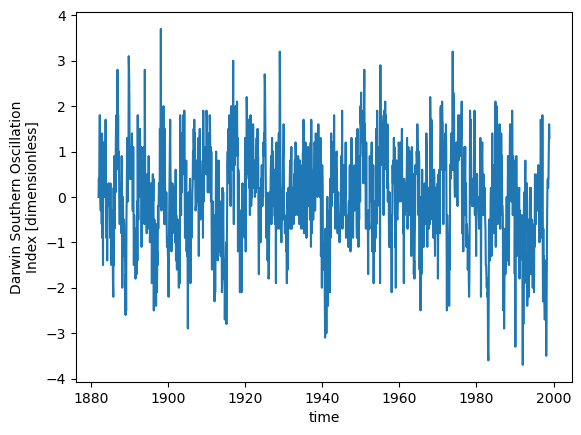

In [4]:
soi = soi_darwin.DSOI
soi['time'] = datetime_index

soi.plot();

### Detrend

Here we will do a simple detrending by removing the mean with [`scipy.signal.detrend()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html).

If you wanted to perform a linear least-squares fit, change `type='linear'`.

The `scipy.signal.periodogram()` function does have a detrending option, but because we are using an unsupported tapering window, and because detrending must be done before tapering, here we demonstrate how to separate out these steps.

In [5]:
soi_detrended = scipy.signal.detrend(soi, type='constant')

### Tapering

According to the code in [NCL's `taper.f`](https://github.com/NCAR/ncl/blob/edd46f5426286146313b31bd6826e3d3c360c0dc/ni/src/lib/nfpfort/taper.f), the tapering performed in the NCL example is split-cosine-bell tapering.

NCL also has a [`taper_n()`](https://www.ncl.ucar.edu/Document/Functions/Built-in/taper_n.shtml) function that is preferable for performing tapering on specific dimensions, and is reported to be faster.

It is unclear which tapering function is used within the NCL spectral analysis functions.

Split-cosine-bell tapering is sometimes identified to as Tukey tapering, however Tukey can also refer to "cosine tapering".

Here we demonstrate how to perform a unique tapering window with [`scipy.signal.windows.tukey`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.tukey.html). Your desired tapering can be chosen instead.

In [6]:
percent_taper = 0.1
tukey_window = scipy.signal.windows.tukey(
    len(soi_detrended), alpha=percent_taper, sym=False
)  # generates a periodic window

soi_tapered = soi_detrended * tukey_window

### Periodogram

Now we can call [`scipy.signal.periodogram()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html).

A periodogram estimate is the square of the coefficients from the Fourier transform

There is also a `scaling` keyword that defaults to `density` for computing the power spectral density with units of $V^{2}/Hz$, with V being the units of the input array (here dimensionless), and `Hz` representing your frequency units (we'll use per month instead of per second). `spectral` is also supported and produces the squared magnitude spectrum with units of $V^{2}$.

In [7]:
freq_soi, psd_soi = scipy.signal.periodogram(
    soi_tapered,
    fs=1,  # sample monthly
    detrend=False,
)

### Smoothing

To provide statistical reliability, the periodogram estimates **must be smoothed**.

The NCL example uses modified Daniel kernel smoothing, which is not supported, here we'll demonstrate how to perform your own custom smoothing using [`scipy.signal.convolve()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).

Here is a [list of supported smoothing windows](https://docs.scipy.org/doc/scipy/reference/signal.windows.html).

In [8]:
k = 7  # define smoothing constant

kernel = np.ones(7)  # Create a Daniel smoothing kernel
kernel[0] = (
    0.5  # "Modify" kernel by making the endpoints have half the weight of the interior points
)
kernel[-1] = 0.5
kernel = kernel / kernel.sum()

smoothed_psd = scipy.signal.convolve(
    psd_soi, kernel, mode='same'
)  # Sets output array as the same length as the first input

### Normalization

Lastly we'll normalize our smoothed periodogram by the variance of the detrended and tapered series.

In [9]:
variance = np.var(soi_tapered, ddof=1)

df = freq_soi[1] - freq_soi[0]  # Frequency step

# Create an array to adjust contributions of endpoints
frac = np.ones_like(freq_soi)
frac[0] = 0.5
frac[-1] = 0.5

current_area = np.sum(
    smoothed_psd * df * frac
)  # Calculate the current area under the curve
normalization_factor = variance / current_area  # Find the factor to adjust this area

normalized_psd = (
    smoothed_psd * normalization_factor
)  # Apply the normalization factor to the smoothed power spectrum

### Plot

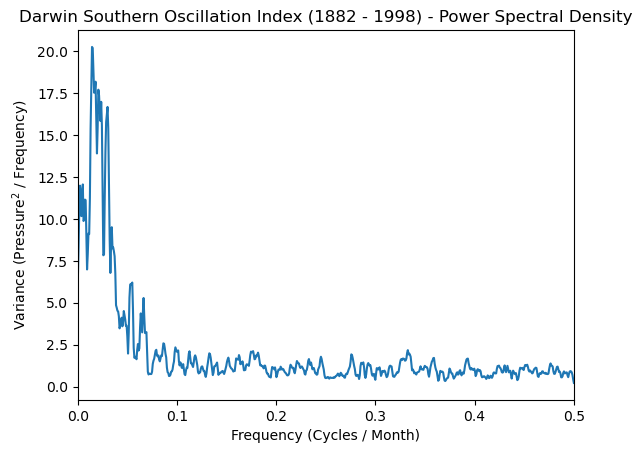

In [10]:
plt.plot(freq_soi, normalized_psd)
plt.xlabel('Frequency (Cycles / Month)')
plt.ylabel('Variance (Pressure$^2$ / Frequency)')
plt.title('Darwin Southern Oscillation Index (1882 - 1998) - Power Spectral Density')
plt.xlim([0, 0.5]);

## 2-D Spectral Analysis

### Read in Data

For our 2-dimensional spectral data we'll look `SLP_DarwinTahitiAnom` which contains Darwin and Tahiti sea level pressure anomalies between 1935-1998.

This data will need a time index correction to use the standard `DateTimeIndex`.

In [11]:
slp_darwin = xr.open_dataset(gcd.get('netcdf_files/SLP_DarwinTahitiAnom.nc'))

# Time Series Correction
start_date = pd.Timestamp('1935-01-01')  # Months Since January 1935
dates = [
    start_date + pd.DateOffset(months=int(month))
    for month in slp_darwin.indexes['time']
]
datetime_index = pd.DatetimeIndex(dates)

slp_darwin['time'] = datetime_index
slp_darwin

<xarray.Dataset> Size: 18kB
Dimensions:  (time: 768)
Coordinates:
  * time     (time) datetime64[ns] 6kB 1935-01-01 1935-02-01 ... 1998-12-01
Data variables:
    date     (time) float64 6kB ...
    DSLP     (time) float32 3kB ...
    TSLP     (time) float32 3kB ...
Attributes:
    title:          Darwin and Tahiti Sea Level Pressure Anomalies: 1935-1998
    source:         Climate Analysis Section, NCAR
    history:        \nCreated to test specxy routines
    creation_date:  Tue Mar 30 12:34:39 MST 1999
    conventions:    None

In [12]:
dslp = slp_darwin.DSLP  # Darwin
dslp

<xarray.DataArray 'DSLP' (time: 768)> Size: 3kB
[768 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 6kB 1935-01-01 1935-02-01 ... 1998-12-01
Attributes:
    short_name:  DSLP
    long_name:   Darwin Sea Level Pressure Anomalies
    units:       hPa

In [13]:
tslp = slp_darwin.TSLP  # Tahiti
tslp

<xarray.DataArray 'TSLP' (time: 768)> Size: 3kB
[768 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 6kB 1935-01-01 1935-02-01 ... 1998-12-01
Attributes:
    short_name:  TSLP
    long_name:   Tahiti Sea Level Pressure Anomalies
    units:       hPa

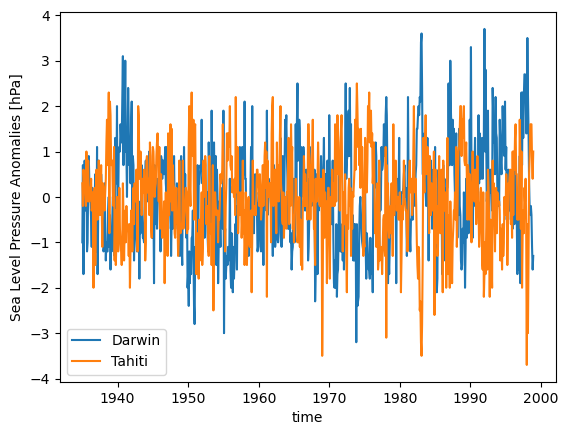

In [14]:
dslp.plot(label='Darwin')
tslp.plot(label='Tahiti')
plt.legend()
plt.ylabel('Sea Level Pressure Anomalies [hPa]');

### Cross-Power Spectral Density

We will calculate cospectrum, quadtrature, and phase by leveraging [`scipy.signal.csd()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html) and computing its real (cospectrum) and imaginary (quadtrature) components, and calculating the angle between them (phase).

In [15]:
f, pxy = scipy.signal.csd(
    dslp,
    tslp,
    fs=1,  # monthly
    detrend='constant',
)  # remove mean

cospectrum = np.real(pxy)
quadrature = np.imag(pxy)

phase = np.angle(pxy, deg=True)

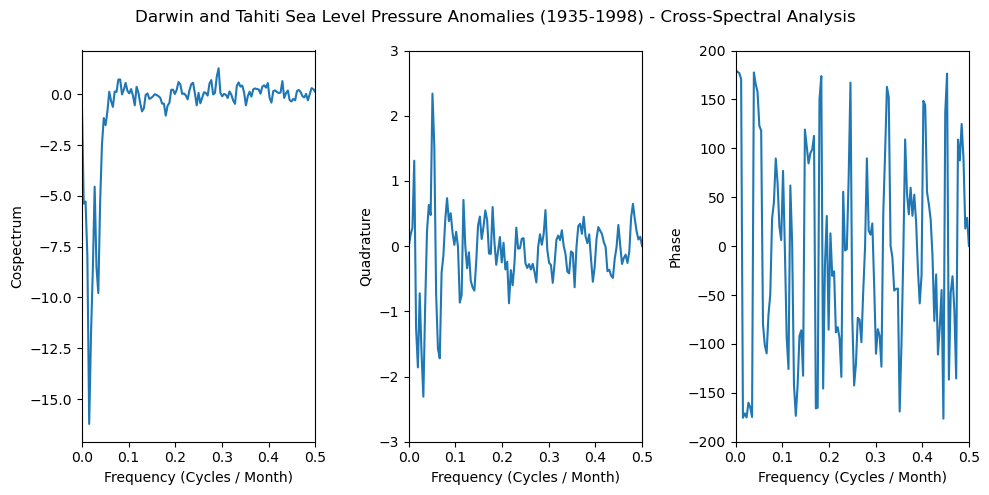

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].plot(f, cospectrum)
axs[0].set_xlim([0, 0.5])
axs[0].set_xlabel('Frequency (Cycles / Month)')
axs[0].set_ylabel('Cospectrum')

axs[1].plot(f, quadrature)
axs[1].set_xlim([0, 0.5])
axs[1].set_ylim([-3, 3])
axs[1].set_xlabel('Frequency (Cycles / Month)')
axs[1].set_ylabel('Quadrature')

axs[2].plot(f, phase)
axs[2].set_xlim([0, 0.5])
axs[2].set_ylim([-200, 200])
axs[2].set_xlabel('Frequency (Cycles / Month)')
axs[2].set_ylabel('Phase')

fig.suptitle(
    'Darwin and Tahiti Sea Level Pressure Anomalies (1935-1998) - Cross-Spectral Analysis'
)

plt.tight_layout();  # Makes the plots y-labels not overlap the neighboring plot

### Coherence Squared

Coherence is a measure of how similar two specta are, with regards to their frequency and phase offset relative to one another. 

For coherence squared, simply square the output from [`scipy.signal.coherence()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html).

In [17]:
f, cxy = scipy.signal.coherence(
    dslp,
    tslp,
    fs=1,  # monthly
    detrend='constant',
)  # remove mean

co_sq = cxy**2

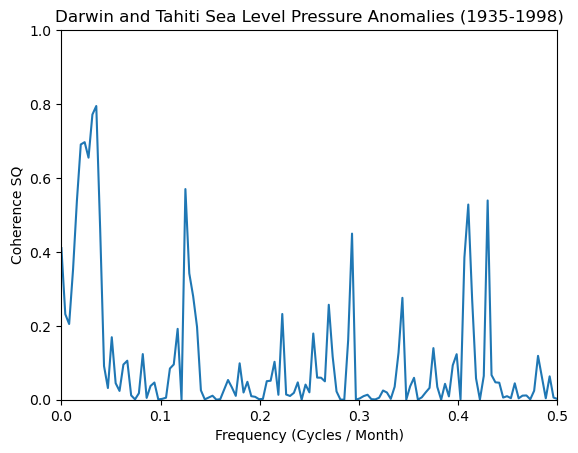

In [18]:
plt.plot(f, co_sq)
plt.xlim([0, 0.5])
plt.ylim([0, 1])
plt.xlabel('Frequency (Cycles / Month)')
plt.ylabel('Coherence SQ')

plt.title('Darwin and Tahiti Sea Level Pressure Anomalies (1935-1998)');

### Peridogram and Smoothing

Previously we demonstrated additional tapering and normalization steps for the periodgram. Now we demonstrate a faster working example for our Darwin and Tahiti datasets.

In [19]:
# Calculate Periodogram
freq_dslp, dslp_psd = scipy.signal.periodogram(
    dslp,
    fs=1,  # monthly
    detrend='constant',
)  # remove mean
freq_tslp, tslp_psd = scipy.signal.periodogram(tslp, fs=1, detrend='constant')


# Perform modified Daniel Smoothing
k = 3  # smoothing constant

window = scipy.signal.windows.hann(2 * k + 1)  # Hann Window
window = window / window.sum()  # Normalize window

dslp_smoothed = scipy.signal.convolve(dslp_psd, window, mode='same')
tslp_smoothed = scipy.signal.convolve(tslp_psd, window, mode='same')

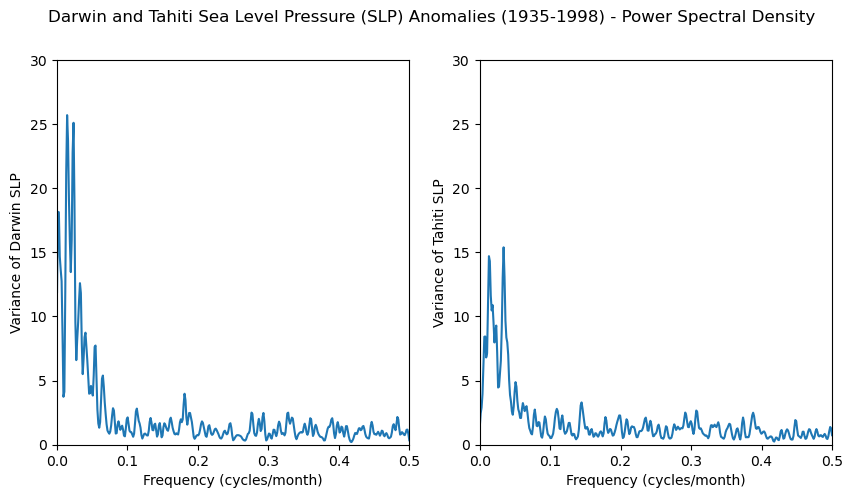

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(freq_dslp, dslp_smoothed)
axs[0].set_xlim([0, 0.5])
axs[0].set_ylim([0, 30])
axs[0].set_xlabel('Frequency (cycles/month)')
axs[0].set_ylabel('Variance of Darwin SLP')

axs[1].plot(freq_tslp, tslp_smoothed)
axs[1].set_xlim([0, 0.5])
axs[1].set_ylim([0, 30])
axs[1].set_xlabel('Frequency (cycles/month)')
axs[1].set_ylabel('Variance of Tahiti SLP')

fig.suptitle(
    'Darwin and Tahiti Sea Level Pressure (SLP) Anomalies (1935-1998) - Power Spectral Density'
);

Curious about how to more closely replicate the NCL version of spectral analysis? Check out our ['NCL Spectral Analysis Notebook']('../../ncl/NCL_spectral_analysis.ipynb')